This notebook is part of the week 4 assignment for the [course](https://github.com/Aggregate-Intellect/maven-course/blob/main/) .In case you prefer working with notebooks or had any issues with setting up required tools as part of week 1 assignment, you can use this notebook on [google colab](https://colab.research.google.com/) in place of running the agent locally.

# Libraries Required for the Assignment 4

In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain-community langchain_openai tavily-python langgraph langchain_experimental

# Setup Required APIs

In [2]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

OPENAI_API_KEY:··········
TAVILY_API_KEY:··········


# Imports

In [115]:
from typing import Literal, Annotated, TypedDict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import Tool
from langchain_core.output_parsers import StrOutputParser


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

# Agent Workflow Logic

In [144]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool


tavily_tool = TavilySearchResults(max_results=2)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [145]:
# Define the structured output for the Researcher node
class ResearcherResponse(BaseModel):
    """Respond to the user with this"""
    Net_Profit_year_1: float = Field(description="Forecasted net profit to bauch health after sales of wieght loss drug in year 1")
    Net_Profit_year_2: float = Field(description="Forecasted net profit to bauch health after sales of wieght loss drug in year 2")
    Net_Profit_year_3: float = Field(description="Forecasted net profit to bauch health after sales of wieght loss drug in year 3")
    Cost_of_Investment_year_1: float = Field(description="Forecasted cost of investment to bauch health for the wieght loss drug in year 1")
    Cost_of_Investment_year_2: float = Field(description="Forecasted cost of investment to bauch health for the wieght loss drug in year 2")
    Cost_of_Investment_year_3: float = Field(description="Forecasted cost of investment to bauch health for the wieght loss drug in year 3")

In [146]:
# Define the structured output for the Researcher node
class CritiqueResponse(BaseModel):
    """Respond to the user with this"""
    proposal_feedback: str = Field(description="Feedback of the critique agent on the sales proposal generated for the weight loss drug by the proposal agent")
    accept: bool = Field(description="Whether to accept the proposal or not")

In [147]:
# Define the state with a messages key and a step counter
class AgentState(MessagesState):
    step_count: int
    researcher_response: ResearcherResponse
    proposal: str
    proposal_accepted: bool
    graph_code: str

In [148]:
# Define the node that calls the model
def call_research_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with state_modifier, but is a lot more flexible
    system_prompt = SystemMessage("You are a helpful AI assistant, please respond to the users query to the best of your ability!")
    model = ChatOpenAI(model="gpt-4o-mini")
    tools = [tavily_tool]
    model = model.bind_tools(tools)
    response = model.invoke([system_prompt] + state['messages'], config)
    # We return a list, because this will get added to the existing list
    current_count = state.setdefault('step_count', 0)
    return {"messages": [response], 'step_count': current_count + 1}

In [149]:
# Define the function that responds to the user
def respond(state: AgentState):
    # We call the model with structured output in order to return the same format to the user every time
    # state['messages'][-2] is the last ToolMessage in the convo, which we convert to a HumanMessage for the model to use
    # We could also pass the entire chat history, but this saves tokens since all we care to structure is the output of the tool
    model = ChatOpenAI(model="gpt-4o-mini")
    response = model.with_structured_output(ResearcherResponse).invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    return {'proposal':state['messages'][-1].content,"researcher_response": response}

In [157]:
# Define the node that calls the model
def call_critique_model(
    state: AgentState,
    config: RunnableConfig,
):
    critique_prompt = """You are tasked with reviewing a sales proposal generated by a LLM. Review the proposal and provide
    clear feedback and actionable feedback on any spelling mistakes, don't comment on any other aspect.
    If it seems like the proposal is fine, then in proposal feedback mention that the proposal is good and accept the proposal.
    Otherwise provide concise proposal feedback and reject the proposal.
    """
    model = ChatOpenAI(model="gpt-4o-mini")
    messages = [
                   {"role": "user", "content": critique_prompt},
                    {"role": "assistant", "content": state['proposal']},
               ]
    response = model.with_structured_output(CritiqueResponse).invoke(messages)
    # We return a list, because this will get added to the existing list
    accepted = response.accept
    if accepted:
        return {
            "messages": [
                {"role": "user", "content": response.proposal_feedback},
                {"role": "assistant", "content": "okay, sending to this to coder agent"}],
            "proposal_accepted": True
        }
    else:
        return {
            "messages": [
                {"role": "user", "content": response.proposal_feedback},
            ],
            "proposal_accepted": False
        }

In [158]:
def route_critique(state: AgentState) -> Literal["research_agent", 'coder']:
    if state['proposal_accepted'] or state['step_count'] > 3:
        return 'coder'
    else:
        return "research_agent"

In [159]:
# Define the node that calls the model
def call_coder_model(
    state: AgentState,
    config: RunnableConfig,
):
    coder_prompt = """You are tasked creating a graph from a sales proposal generated by a LLM.
    Using the proposal write a clear, executable python code for creating a graph representing the forecasted ROI for next 3 years.
    The output should be executable python code only.
    """
    coder_agent_context = f"""
    proposal: {state['proposal']},
    Net_Profit_year_1: {state['researcher_response'].Net_Profit_year_1},
    Net_Profit_year_2: {state['researcher_response'].Net_Profit_year_2},
    Net_Profit_year_3: {state['researcher_response'].Net_Profit_year_3},
    Cost_of_Investment_year_1: {state['researcher_response'].Cost_of_Investment_year_1},
    Cost_of_Investment_year_2: {state['researcher_response'].Cost_of_Investment_year_2},
    Cost_of_Investment_year_3: {state['researcher_response'].Cost_of_Investment_year_3},
    """

    messages = [
                   {"role": "user", "content": coder_prompt},
                    {"role": "assistant", "content": coder_agent_context},
               ]
    model = ChatOpenAI(model="gpt-4o-mini")
    response = model.invoke(messages, config)

    return {"graph_code": response.content}

In [160]:
# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"

In [181]:
search_tool_node = ToolNode([tavily_tool])

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("research_agent", call_research_model)
workflow.add_node("respond", respond)
workflow.add_node("search_tool", search_tool_node)
workflow.add_node('critique', call_critique_model)
workflow.add_node('coder', call_coder_model)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "research_agent")

# We now add a conditional edge
# We now add a conditional edge
workflow.add_conditional_edges(
    "research_agent",
    should_continue,
    {
        "continue": "search_tool",
        "respond": "respond",
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("search_tool", 'research_agent')
workflow.add_edge("respond", 'critique')
workflow.add_conditional_edges("critique", route_critique)
workflow.add_edge("coder", END)

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
# This is so that the memory is initialized with the graph
# This is useful if you want to persist state between runs
graph = workflow.compile(checkpointer=checkpointer, interrupt_before=["coder"])

# Visualize Agent Workflow

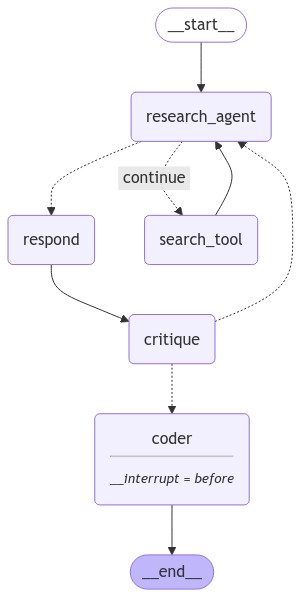

In [232]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Results

In [233]:
import pprint

input_prompt = """You are an AI assistant tasked with creating a proposal for a new weight loss drug to pitch to Bausch Health.
Use the Tavily search tool to gather information about Bausch Health and the pharmaceutical industry.

Your proposal should include:
1. Executive Summary
2. Company Overview (Bausch Health)
3. Product Description
4. Market Analysis
5. Marketing Strategy
6. Financial Projections
   - Include estimated production costs
   - Projected sales and revenue
7. Projections for Net_Profit for next 3 years
8. Projections for Cost_of_Investment for next 3 years

Ensure your proposal is well-structured, informative, and persuasive.
"""

# Run the graph
thread ={"configurable": {"thread_id": 1001}}
state = graph.invoke(
    {"messages": [HumanMessage(content=input_prompt)]},
    config=thread
)

In [234]:
state

{'messages': [HumanMessage(content='You are an AI assistant tasked with creating a proposal for a new weight loss drug to pitch to Bausch Health.\nUse the Tavily search tool to gather information about Bausch Health and the pharmaceutical industry.\n\nYour proposal should include:\n1. Executive Summary\n2. Company Overview (Bausch Health)\n3. Product Description\n4. Market Analysis\n5. Marketing Strategy\n6. Financial Projections\n   - Include estimated production costs\n   - Projected sales and revenue\n7. Projections for Net_Profit for next 3 years\n8. Projections for Cost_of_Investment for next 3 years\n\nEnsure your proposal is well-structured, informative, and persuasive.\n', additional_kwargs={}, response_metadata={}, id='e7fac508-d07d-4657-a4ac-e3694f8700ca'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9itMkKKDcPkENrxZx2yUx07P', 'function': {'arguments': '{"query": "Bausch Health overview"}', 'name': 'tavily_search_results_json'}, 'type': 'function'},

Q. Final proposal

In [235]:
state['proposal']

"### Proposal for a New Weight Loss Drug to Pitch to Bausch Health\n\n#### 1. Executive Summary\nThe obesity epidemic presents a significant public health challenge and a lucrative opportunity in the pharmaceutical market. This proposal outlines the development of a new weight loss drug aimed at providing safe and effective solutions for patients struggling with obesity. With Bausch Health's commitment to improving Health Outcomes, this drug aligns perfectly with their mission and business strategy.\n\n#### 2. Company Overview (Bausch Health)\nBausch Health Companies, Inc. is a global, diversified pharmaceutical company dedicated to enhancing lives through innovative health products. The company develops, manufactures, and markets a range of products primarily in gastroenterology, neurology, dermatology, and international pharmaceuticals. Bausch Health emphasizes delivering better Health Outcomes and improving people's lives through its pharmaceutical products ([Bausch Health](https://

Q. Was Proposal Accepted by the Crtique Model




In [236]:
state['proposal_accepted']

True

Human input changing state, changing year 3 net profit to 29 M, this is how we can proivde human input to change state of the workflow

In [237]:
state['researcher_response'].Net_Profit_year_3

30000000.0

In [238]:
state['researcher_response'].Net_Profit_year_3 = 29000000.0

In [239]:
state['researcher_response'].Net_Profit_year_3

29000000.0

If proposal look good go to next step for getting the code using LLM for building graph

In [240]:
graph_code = None

In [241]:
for event in graph.stream(None, thread, stream_mode="values"):
    if 'graph_code' in event.keys():
        graph_code = event['graph_code']
        break

Q. Verify the code for graph

In [246]:
def check_formatting(code):
        # Check if the code contains markdown formatting with triple backticks
        if "```" in code:
            # Split the code by newlines
            lines = code.split('\n')
            # Filter out lines that start or end with triple backticks
            executable_lines = [line for line in lines if not line.strip().startswith('```')]
            # Join the remaining lines back into a single string
            return '\n'.join(executable_lines)
        else:
            # If no markdown formatting is detected, return the input as is
            return code

In [248]:
executable_code = check_formatting(graph_code)
print(executable_code)

import matplotlib.pyplot as plt
import numpy as np

# Data for the forecasted ROI
years = np.array([1, 2, 3])
net_profit = np.array([-5000000, 10000000, 30000000])
cost_of_investment = np.array([15000000, 10000000, 5000000])

# Calculating ROI
roi = net_profit / cost_of_investment

# Creating the bar graph
plt.figure(figsize=(10, 6))
plt.bar(years - 0.2, roi, width=0.4, label='ROI', color='blue')
plt.axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
plt.xticks(years)
plt.title('Forecasted ROI for the Next 3 Years')
plt.xlabel('Year')
plt.ylabel('ROI (Net Profit / Cost of Investment)')
plt.ylim(-2, 3)  # Set y-axis limits for better visibility
plt.grid(axis='y')

# Adding data labels on top of the bars
for i in range(len(roi)):
    plt.text(years[i] - 0.2, roi[i] + 0.1, f'{roi[i]:.2f}', ha='center')

plt.legend()
plt.show()


Execute code

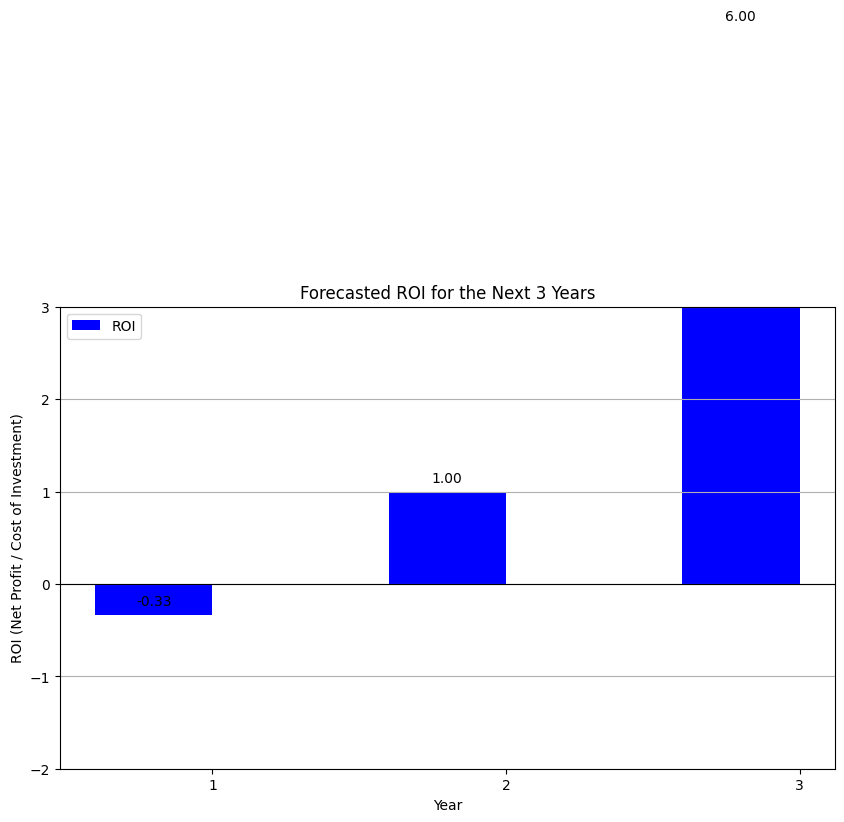

In [249]:
exec(executable_code)